In [3]:
# Install required packages
!pip install sentence-transformers numpy scikit-learn pandas tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.7 MB ? eta -:--:--Downloading tf_keras-2.20.1-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.3 MB/s  0:00:00


In [4]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

## Sample Document Collection

Creating a knowledge base with documents about machine learning topics.

In [5]:
# Sample documents (knowledge base)
documents = [
    "Machine learning is a subset of artificial intelligence that focuses on building systems that learn from data.",
    "Deep learning uses neural networks with multiple layers to learn hierarchical representations of data.",
    "Natural language processing enables computers to understand, interpret, and generate human language.",
    "Computer vision allows machines to interpret and understand visual information from the world.",
    "Reinforcement learning trains agents to make decisions by rewarding desired behaviors.",
    "Supervised learning uses labeled data to train models that can make predictions on new data.",
    "Unsupervised learning discovers patterns in data without explicit labels or supervision.",
    "Transfer learning leverages knowledge from pre-trained models to solve new related tasks.",
    "Neural networks are computing systems inspired by biological neural networks in animal brains.",
    "Gradient descent is an optimization algorithm used to minimize loss functions in machine learning.",
    "Overfitting occurs when a model learns the training data too well and fails to generalize.",
    "Cross-validation is a technique to assess model performance by splitting data into train and test sets.",
    "Feature engineering involves creating new features from raw data to improve model performance.",
    "Ensemble methods combine multiple models to produce better predictions than individual models.",
    "Convolutional neural networks are specialized for processing grid-like data such as images.",
]

print(f"Knowledge base contains {len(documents)} documents\n")
print("Sample documents:")
for i, doc in enumerate(documents[:3]):
    print(f"{i+1}. {doc}")

Knowledge base contains 15 documents

Sample documents:
1. Machine learning is a subset of artificial intelligence that focuses on building systems that learn from data.
2. Deep learning uses neural networks with multiple layers to learn hierarchical representations of data.
3. Natural language processing enables computers to understand, interpret, and generate human language.


## Text Chunking and Preparation

Organizing documents into a structured format for retrieval.

In [6]:
# Create structured document database
doc_database = pd.DataFrame({
    'doc_id': range(len(documents)),
    'content': documents
})

print("Document Database:")
print(doc_database.head(10))
print(f"\nTotal documents: {len(doc_database)}")

Document Database:
   doc_id                                            content
0       0  Machine learning is a subset of artificial int...
1       1  Deep learning uses neural networks with multip...
2       2  Natural language processing enables computers ...
3       3  Computer vision allows machines to interpret a...
4       4  Reinforcement learning trains agents to make d...
5       5  Supervised learning uses labeled data to train...
6       6  Unsupervised learning discovers patterns in da...
7       7  Transfer learning leverages knowledge from pre...
8       8  Neural networks are computing systems inspired...
9       9  Gradient descent is an optimization algorithm ...

Total documents: 15


## Embedding Generation

Using SentenceTransformer to convert documents into dense vector representations.

In [7]:
# Load embedding model
MODEL_NAME = 'all-MiniLM-L6-v2'
print(f"Loading embedding model: {MODEL_NAME}")
embedding_model = SentenceTransformer(MODEL_NAME)

print(f"Model loaded successfully")
print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

Loading embedding model: all-MiniLM-L6-v2
Model loaded successfully
Embedding dimension: 384
Model loaded successfully
Embedding dimension: 384


In [8]:
# Generate embeddings for all documents
print("Generating embeddings for documents...")
doc_embeddings = embedding_model.encode(documents, show_progress_bar=True)

print(f"\nEmbeddings shape: {doc_embeddings.shape}")
print(f"Each document is represented as a {doc_embeddings.shape[1]}-dimensional vector")

# Add embeddings to database
doc_database['embedding'] = list(doc_embeddings)
print("\nEmbeddings added to database")

Generating embeddings for documents...


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Embeddings shape: (15, 384)
Each document is represented as a 384-dimensional vector

Embeddings added to database


## Cosine Similarity Retrieval

Implementing retrieval function to find most relevant documents for a query.

In [9]:
def retrieve_documents(query, top_k=3):
    """
    Retrieve most relevant documents for a query using cosine similarity
    
    Args:
        query: Search query string
        top_k: Number of documents to retrieve
    
    Returns:
        DataFrame with retrieved documents and similarity scores
    """
    # Generate query embedding
    query_embedding = embedding_model.encode([query])
    
    # Calculate cosine similarity between query and all documents
    similarities = cosine_similarity(query_embedding, doc_embeddings)[0]
    
    # Get top-k most similar documents
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # Create results dataframe
    results = pd.DataFrame({
        'rank': range(1, top_k + 1),
        'doc_id': top_indices,
        'similarity': similarities[top_indices],
        'content': [documents[i] for i in top_indices]
    })
    
    return results

print("Retrieval function ready")

Retrieval function ready


## Testing Retrieval System

Running queries to test document retrieval effectiveness.

In [10]:
# Test Query 1
query_1 = "How do neural networks work?"

print(f"Query: {query_1}")
print("=" * 80)

results_1 = retrieve_documents(query_1, top_k=3)

print("\nTop 3 Retrieved Documents:")
for _, row in results_1.iterrows():
    print(f"\nRank {row['rank']} (Similarity: {row['similarity']:.4f})")
    print(f"  {row['content']}")

Query: How do neural networks work?

Top 3 Retrieved Documents:

Rank 1 (Similarity: 0.6776)
  Neural networks are computing systems inspired by biological neural networks in animal brains.

Rank 2 (Similarity: 0.5859)
  Deep learning uses neural networks with multiple layers to learn hierarchical representations of data.

Rank 3 (Similarity: 0.4806)
  Convolutional neural networks are specialized for processing grid-like data such as images.


In [11]:
# Test Query 2
query_2 = "What is the difference between supervised and unsupervised learning?"

print(f"Query: {query_2}")
print("=" * 80)

results_2 = retrieve_documents(query_2, top_k=3)

print("\nTop 3 Retrieved Documents:")
for _, row in results_2.iterrows():
    print(f"\nRank {row['rank']} (Similarity: {row['similarity']:.4f})")
    print(f"  {row['content']}")

Query: What is the difference between supervised and unsupervised learning?

Top 3 Retrieved Documents:

Rank 1 (Similarity: 0.6664)
  Unsupervised learning discovers patterns in data without explicit labels or supervision.

Rank 2 (Similarity: 0.5105)
  Supervised learning uses labeled data to train models that can make predictions on new data.

Rank 3 (Similarity: 0.3618)
  Machine learning is a subset of artificial intelligence that focuses on building systems that learn from data.


In [12]:
# Test Query 3
query_3 = "Explain computer vision applications"

print(f"Query: {query_3}")
print("=" * 80)

results_3 = retrieve_documents(query_3, top_k=3)

print("\nTop 3 Retrieved Documents:")
for _, row in results_3.iterrows():
    print(f"\nRank {row['rank']} (Similarity: {row['similarity']:.4f})")
    print(f"  {row['content']}")

Query: Explain computer vision applications

Top 3 Retrieved Documents:

Rank 1 (Similarity: 0.7275)
  Computer vision allows machines to interpret and understand visual information from the world.

Rank 2 (Similarity: 0.3830)
  Natural language processing enables computers to understand, interpret, and generate human language.

Rank 3 (Similarity: 0.3824)
  Convolutional neural networks are specialized for processing grid-like data such as images.


## Similarity Analysis

Visualizing similarity scores across different queries.

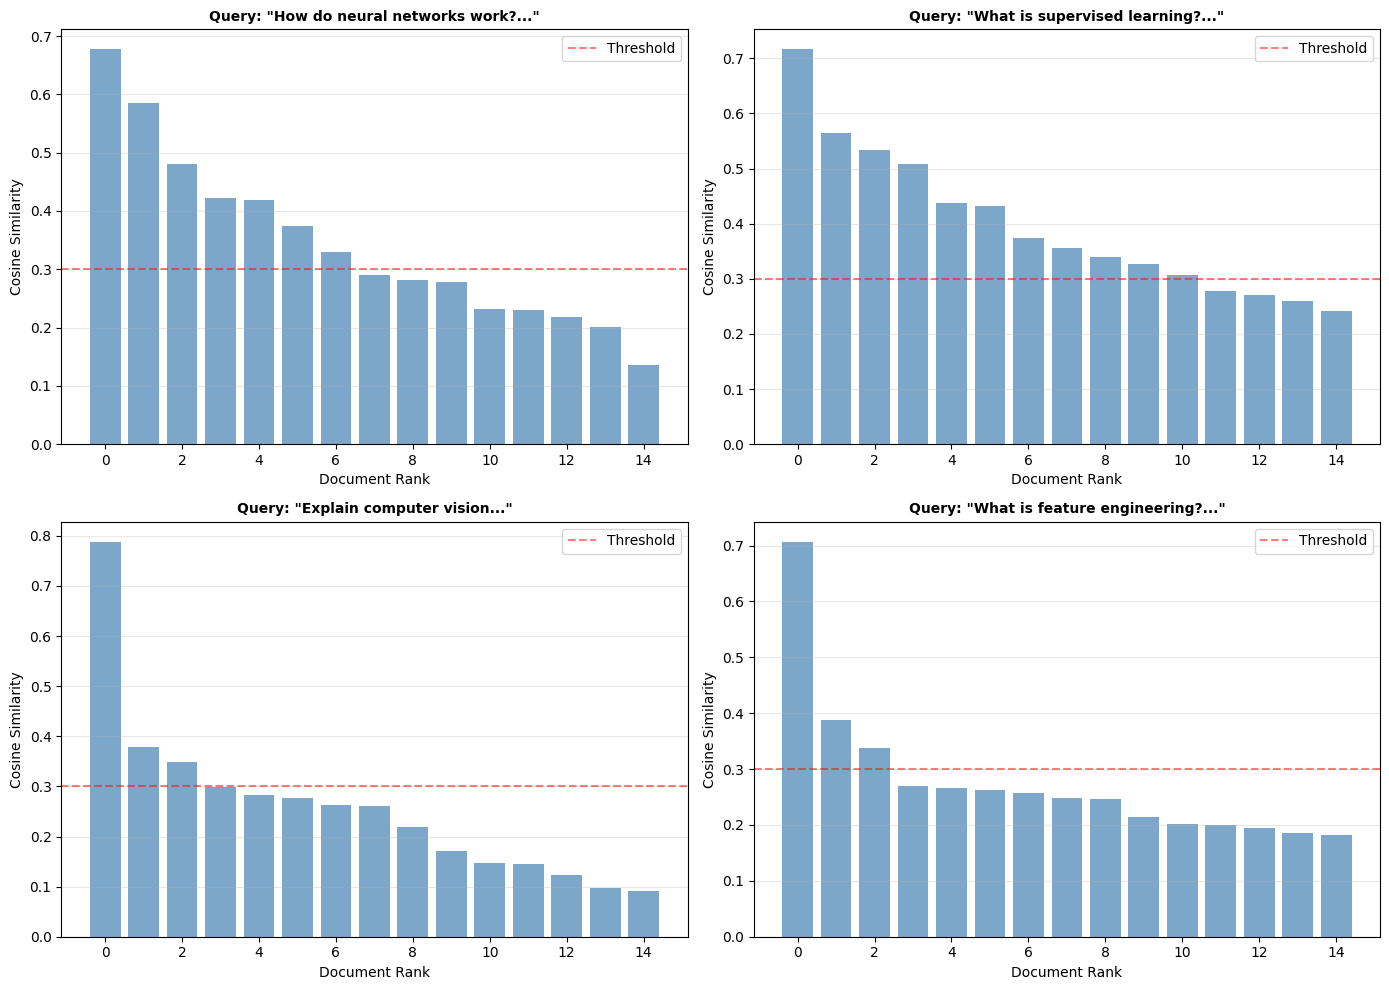

In [13]:
import matplotlib.pyplot as plt

# Analyze similarity distributions for different queries
test_queries = [
    "How do neural networks work?",
    "What is supervised learning?",
    "Explain computer vision",
    "What is feature engineering?"
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, query in enumerate(test_queries):
    # Get embeddings
    query_emb = embedding_model.encode([query])
    similarities = cosine_similarity(query_emb, doc_embeddings)[0]
    
    # Sort for visualization
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_similarities = similarities[sorted_indices]
    
    # Plot
    axes[idx].bar(range(len(similarities)), sorted_similarities, color='steelblue', alpha=0.7)
    axes[idx].axhline(y=0.3, color='red', linestyle='--', alpha=0.5, label='Threshold')
    axes[idx].set_title(f'Query: "{query[:40]}..."', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Document Rank')
    axes[idx].set_ylabel('Cosine Similarity')
    axes[idx].grid(alpha=0.3, axis='y')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## Context-Based Answer Generation

Simulating answer generation using retrieved context (without LLM).

In [14]:
def generate_answer(query, top_k=3):
    """
    Generate answer by retrieving relevant context
    
    Args:
        query: User question
        top_k: Number of documents to retrieve
    
    Returns:
        Dictionary with query, retrieved context, and summary
    """
    # Retrieve relevant documents
    results = retrieve_documents(query, top_k)
    
    # Combine retrieved documents as context
    context = "\n\n".join([f"[{i+1}] {row['content']}" 
                           for i, (_, row) in enumerate(results.iterrows())])
    
    # Calculate average similarity
    avg_similarity = results['similarity'].mean()
    
    return {
        'query': query,
        'context': context,
        'num_docs': len(results),
        'avg_similarity': avg_similarity,
        'results': results
    }

print("Answer generation function ready")

Answer generation function ready


In [15]:
# Generate answer for a query
query = "What techniques help prevent overfitting in machine learning models?"

answer_data = generate_answer(query, top_k=4)

print("=" * 80)
print("QUERY:")
print(answer_data['query'])
print("\n" + "=" * 80)
print("RETRIEVED CONTEXT:")
print(answer_data['context'])
print("\n" + "=" * 80)
print("METADATA:")
print(f"  Documents Retrieved: {answer_data['num_docs']}")
print(f"  Average Similarity: {answer_data['avg_similarity']:.4f}")
print("\n" + "=" * 80)
print("SIMILARITY SCORES:")
for _, row in answer_data['results'].iterrows():
    print(f"  Doc {row['doc_id']}: {row['similarity']:.4f}")

QUERY:
What techniques help prevent overfitting in machine learning models?

RETRIEVED CONTEXT:
[1] Overfitting occurs when a model learns the training data too well and fails to generalize.

[2] Ensemble methods combine multiple models to produce better predictions than individual models.

[3] Cross-validation is a technique to assess model performance by splitting data into train and test sets.

[4] Machine learning is a subset of artificial intelligence that focuses on building systems that learn from data.

METADATA:
  Documents Retrieved: 4
  Average Similarity: 0.4397

SIMILARITY SCORES:
  Doc 10: 0.7082
  Doc 13: 0.3738
  Doc 11: 0.3459
  Doc 0: 0.3309


## Interactive Query System

Simple interface for querying the knowledge base.

In [16]:
def interactive_query(query, top_k=3, show_scores=True):
    """Interactive query interface"""
    print("=" * 80)
    print(f"QUERY: {query}")
    print("=" * 80)
    
    results = retrieve_documents(query, top_k)
    
    print(f"\nRetrieved {len(results)} most relevant documents:\n")
    
    for _, row in results.iterrows():
        print(f"📄 Rank {row['rank']}")
        if show_scores:
            print(f"   Similarity: {row['similarity']:.4f}")
        print(f"   Content: {row['content']}\n")
    
    return results

# Test interactive system
test_queries = [
    "What is transfer learning?",
    "How does gradient descent optimize models?",
    "What are ensemble methods?"
]

for test_query in test_queries:
    interactive_query(test_query, top_k=2)
    print("\n")

QUERY: What is transfer learning?

Retrieved 2 most relevant documents:

📄 Rank 1
   Similarity: 0.6405
   Content: Transfer learning leverages knowledge from pre-trained models to solve new related tasks.

📄 Rank 2
   Similarity: 0.4427
   Content: Supervised learning uses labeled data to train models that can make predictions on new data.



QUERY: How does gradient descent optimize models?

Retrieved 2 most relevant documents:

📄 Rank 1
   Similarity: 0.7336
   Content: Gradient descent is an optimization algorithm used to minimize loss functions in machine learning.

📄 Rank 2
   Similarity: 0.3489
   Content: Deep learning uses neural networks with multiple layers to learn hierarchical representations of data.



QUERY: What are ensemble methods?

Retrieved 2 most relevant documents:

📄 Rank 1
   Similarity: 0.6862
   Content: Ensemble methods combine multiple models to produce better predictions than individual models.

📄 Rank 2
   Similarity: 0.3373
   Content: Cross-validation i

## Evaluation Metrics

Analyzing retrieval quality and similarity distributions.

In [17]:
# Calculate statistics across multiple queries
evaluation_queries = [
    "neural networks architecture",
    "supervised vs unsupervised learning",
    "deep learning methods",
    "model evaluation techniques",
    "optimization algorithms"
]

stats = []

for query in evaluation_queries:
    results = retrieve_documents(query, top_k=5)
    stats.append({
        'query': query,
        'max_similarity': results['similarity'].max(),
        'mean_similarity': results['similarity'].mean(),
        'min_similarity': results['similarity'].min(),
        'std_similarity': results['similarity'].std()
    })

stats_df = pd.DataFrame(stats)

print("Retrieval Quality Statistics:")
print("=" * 80)
print(stats_df.to_string(index=False))

print("\n" + "=" * 80)
print("Overall Statistics:")
print(f"  Average Max Similarity: {stats_df['max_similarity'].mean():.4f}")
print(f"  Average Mean Similarity: {stats_df['mean_similarity'].mean():.4f}")
print(f"  Average Std Similarity: {stats_df['std_similarity'].mean():.4f}")

Retrieval Quality Statistics:
                              query  max_similarity  mean_similarity  min_similarity  std_similarity
       neural networks architecture        0.577817         0.446159        0.324894        0.110516
supervised vs unsupervised learning        0.698314         0.470825        0.347982        0.154881
              deep learning methods        0.584070         0.427859        0.333461        0.099015
        model evaluation techniques        0.406408         0.291347        0.201862        0.090416
            optimization algorithms        0.526759         0.297828        0.205891        0.130063

Overall Statistics:
  Average Max Similarity: 0.5587
  Average Mean Similarity: 0.3868
  Average Std Similarity: 0.1170


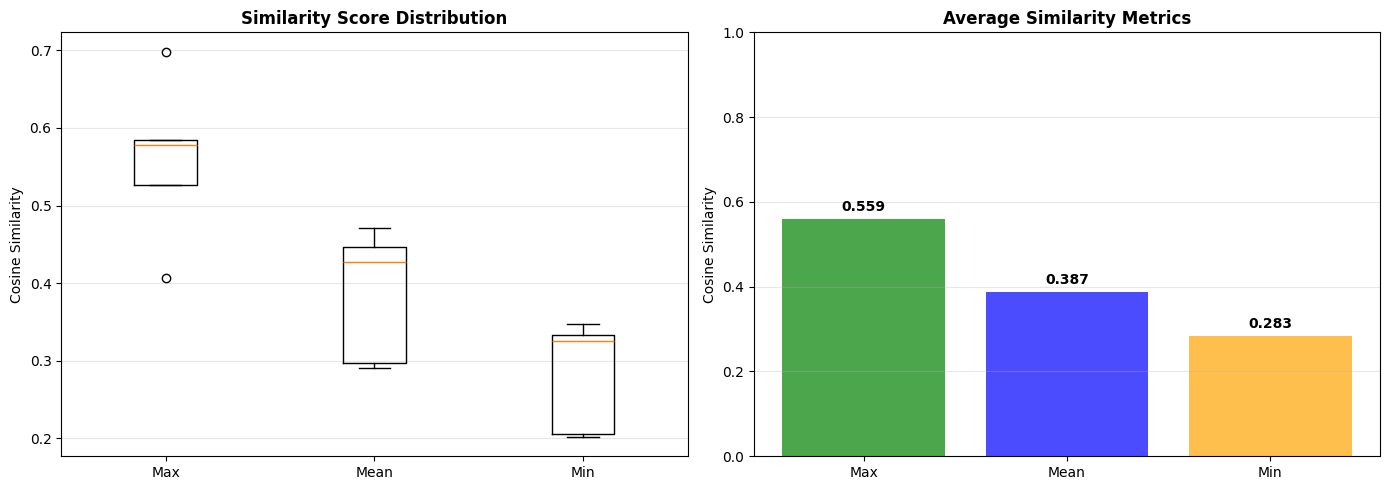

In [18]:
# Visualize overall performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of similarities
data_to_plot = [stats_df['max_similarity'], stats_df['mean_similarity'], stats_df['min_similarity']]
axes[0].boxplot(data_to_plot, labels=['Max', 'Mean', 'Min'])
axes[0].set_title('Similarity Score Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cosine Similarity')
axes[0].grid(alpha=0.3, axis='y')

# Bar chart of average metrics
metrics = ['Max', 'Mean', 'Min']
values = [stats_df['max_similarity'].mean(), 
          stats_df['mean_similarity'].mean(), 
          stats_df['min_similarity'].mean()]

axes[1].bar(metrics, values, color=['green', 'blue', 'orange'], alpha=0.7)
axes[1].set_title('Average Similarity Metrics', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.3, axis='y')

for i, v in enumerate(values):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()